In [1]:
import pandas as pd
import numpy as np
import torch
import sys

import gym
from gym import spaces

import talib

sys.path.append("..") 
from data_provider import read_data
from tensorboardX import SummaryWriter

In [3]:
class TradingEnv(gym.Env):
    metadata = {'render.modes': ['human', 'file', 'none']}

    def __init__(self, data, lead_window, lag_window):
        super(TradingEnv, self).__init__()

        self.prices = data['C'].values
        self.initial_balance = 10000
        self.net_worth = self.initial_balance
        self.commission = 0.00075
        self.contract = 10
        self.open_position = 0
        self.profit = 0
    
        self.offset = lag_window
        self.fast = talib.MA(self.prices, lead_window)
        self.slow = talib.MA(self.prices, lag_window)
        ma_diff =  self.fast - self.slow
        ma_diff[:self.offset] = 0
        bins = np.quantile(ma_diff[self.offset:],np.arange(50)/100)
        self.ma_states = np.digitize(ma_diff, bins)
        self.bins = bins
        
        self.action_space = spaces.Discrete(3)
 #       self.observation_space = spaces.Box(low=0, high=1, shape=(2,), dtype=np.float16)   
        n_states = (len(bins) + 1) * 2
        self.observation_space = spaces.Discrete(n_states)      

    def _next_observation(self):
        obs = self.ma_states[self.current_step] * 2 +  int(self.shares_held/self.contract)
        return obs

    def reset(self):
        self.current_step = self.offset
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.shares_held = 0.0
        self.trades = 0
        return self._next_observation()
    
    def _take_action(self, action):
        
   
        current_price = self.prices[self.current_step]        
        
        if action == 1 and self.shares_held== 0 :
            price = current_price * buy_correction
            self.shares_held += self.contract
            cost =  self.contract * price * (1 + self.commission)
            self.balance = self.balance - cost
            self.open_position = self.open_position + cost 
            
        elif action == 2 and self.shares_held > 0:
            price = current_price * sell_correction
            cash = self.contract * price *(1 - self.commission) 
            self.balance = self.balance + cash
            self.profit = cash - self.open_position
            self.open_position =  0
            self.shares_held = 0
            self.trades = self.trades + 1
            
        new_net = self.balance + self.shares_held * current_price * (1 - self.commission) * sell_correction
        self.net_diff = new_net - self.net_worth 
        self.net_worth = new_net

        
    def step(self, action):
        # Execute one time step within the environment
        self._take_action(action)
        self.current_step += 1

        #delay_modifier = (self.current_step / MAX_STEPS)
        #reward = self.balance * delay_modifier + self.current_step
 
        reward = self.net_diff
#        reward = self.profit
#        self.profit = 0
        done = self.net_worth <= 0 or self.current_step >= len(self.prices) - 1
        
        obs = self._next_observation()
        return obs, reward, done, {}     
    

In [8]:
bins = np.quantile(ma_diff[self.offset:],np.arange(3)/100)
self.ma_states = np.digitize(ma_diff, bins)


NameError: name 'ma_diff' is not defined

In [14]:
volumes = data['V'].values
vol_bins = np.quantile(volumes, np.arange(3)/100)
vol_states = np.digitize(volumes, vol_bins)

In [4]:
data = read_data('LINK-USDT', '30m', '2018-02-06')
MAX_STEPS = data.shape[0]
train = round(MAX_STEPS * 0.7)
env = TradingEnv(data.iloc[:train], 78, 105)

action_space = np.stack([np.arange(6) // 2, np.arange(6) % 2 ], axis = 1)
buy_correction =  1.0001
sell_correction   = 0.9999

number_of_states = env.observation_space.n
number_of_actions = env.action_space.n
env.reset()

64

In [5]:
data

,T,O,H,L,C,V
0,1547632800000,0.5355,0.5355,0.5050,0.5146,24874.41
1,1547634600000,0.5146,0.5260,0.5003,0.5066,38490.92
2,1547636400000,0.5146,0.5162,0.5082,0.5100,7277.02
3,1547638200000,0.5080,0.5099,0.4980,0.4980,145952.68
4,1547640000000,0.4980,0.5021,0.4846,0.4892,149928.45
...,...,...,...,...,...,...
22960,1589085000000,3.6444,3.6759,3.5944,3.6651,651305.84
22961,1589086800000,3.6670,3.6847,3.6432,3.6608,308663.05
22962,1589088600000,3.6623,3.6880,3.6507,3.6682,210065.97
22963,1589090400000,3.6686,3.6982,3.6436,3.6924,148195.58


In [48]:
num_episodes = 3000
Q = np.zeros([number_of_states, number_of_actions])
G = 0
alpha = 0.1
gamma = 1
epsilon = 0.7
epsilon_final = 0.01
epsilon_decay = 0.998
writer = SummaryWriter(comment="-trade_env_ma")

for episode in range(1, num_episodes):
    done = False
    G, reward = 0,0
    state = env.reset()
    while done != True:
        random_for_egreedy = np.random.rand()
        if random_for_egreedy > epsilon:    
            action = np.argmax(Q[state]) #1
        else:
            action = env.action_space.sample()
        new_state, reward, done, info = env.step(action) #2

        Q[state,action] = (1 - alpha)*Q[state,action] + alpha*(reward + gamma*np.max(Q[new_state])) #3
        G += reward
        state = new_state   
    writer.add_scalar("reward", G, episode) 
    writer.add_scalar("trades", env.trades, episode)      
    writer.add_scalar("shares", env.shares_held, episode)      
    if epsilon > epsilon_final:
        epsilon *= epsilon_decay

    if episode % int(num_episodes/2) == 0:   
        Q = Q - Q.mean(axis = 1, keepdims = 1)
        
    if episode % 100 == 0:
        print('Episode {} Total Reward: {}, epsilon: {}'.format(episode,  G, epsilon))
writer.close()

Episode 100 Total Reward: -35.24712238771281, epsilon: 0.5729967632818997
Episode 200 Total Reward: -34.251743370767144, epsilon: 0.46903612961647606
Episode 300 Total Reward: -29.110767174304783, epsilon: 0.3839374059035859
Episode 400 Total Reward: -3.403450647407226, epsilon: 0.3142784155508623
Episode 500 Total Reward: -14.557219796271966, epsilon: 0.2572578784000112
Episode 600 Total Reward: -16.11960971167173, epsilon: 0.21058275950282135
Episode 700 Total Reward: -0.8952303545665927, epsilon: 0.17237605656869612
Episode 800 Total Reward: 11.755803511550766, epsilon: 0.1411013178302292
Episode 900 Total Reward: -8.88185954826804, epsilon: 0.11550085487361698
Episode 1000 Total Reward: -6.342348610720364, epsilon: 0.09454516571267851
Episode 1100 Total Reward: 18.101744908331966, epsilon: 0.07739153419616518
Episode 1200 Total Reward: 4.404319415163627, epsilon: 0.06335014085689016
Episode 1300 Total Reward: -8.098065388092436, epsilon: 0.051856322377786396
Episode 1400 Total Rewa

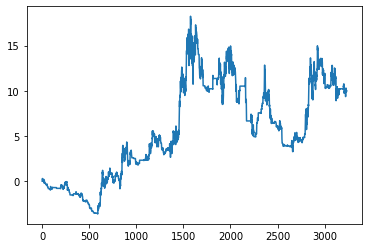

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

env_val = TradingEnv(data.iloc[train:], 78, 105)
state = env_val.reset()
profit = []
done = False
while done != True:
    action = np.argmax(Q[state]) #1
    state, reward, done, info = env_val.step(action) #2

    profit.append(reward)

cum_profit = np.array(profit).cumsum()

plt.plot(cum_profit)
plt.show()

In [ ]:
#num_episodes = 3000
#Q = np.zeros([number_of_states, number_of_actions])
#G = 0
#alpha = 0.1
#gamma = 1
#epsilon = 0.7
#epsilon_final = 0.01
#epsilon_decay = 0.998

In [21]:
#Q - Q.mean(axis = 1)
from sklearn.preprocessing import scale
qs = scale(Q - Q.mean(axis = 1, keepdims = 1), axis =1).round(2)

df = pd.DataFrame(qs)
df.columns= ['hold', 'buy_1', 'sell_1', ]

#ind = np.round((env.bins + 1)*2).astype(int).tolist()
#df.index = ind
#df.apply(lambda x: df.columns[np.argmax(x)], axis =1)
df

,hold,buy_1,sell_1
0,0.00,0.00,0.00
1,0.00,0.00,0.00
2,-0.86,1.40,-0.55
3,1.41,-0.58,-0.83
4,1.10,-1.32,0.21
...,...,...,...
197,1.31,-0.19,-1.12
198,-0.52,1.40,-0.88
199,-0.06,1.25,-1.19
200,-1.16,-0.12,1.28


In [21]:
import collections
x = collections.defaultdict(float)
x[('a','b', 3)] = 3

## Simple Q-learning